In [1]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [ ]:
data = pd.read_csv("/content/drive/Shareddrives/Hackathon/data/cleaned_data/merged_final_2.csv",
                   parse_dates=["WORK_DATE",'DEB_TIME', 'FIN_TIME'])

In [ ]:
target=["WAIT_TIME_MAX"]
datetimes=["WORK_DATE",'DEB_TIME', 'FIN_TIME']
categoricals=["ENTITY_DESCRIPTION_SHORT","NIGHT_SHOW_FLAG","PARADE_1_FLAG","PARADE_2_FLAG", "weather_description"]
numericals=["attendance", "CAPACITY","NB_MAX_UNIT","feels_like"]

In [ ]:
data = data[datetimes + categoricals + numericals + target]

In [ ]:
# shift attendance, lag 7
data["DATE"] = data["WORK_DATE"].dt.date

In [ ]:
data = data.sort_values(by="DEB_TIME",ascending=True).drop(labels=["WORK_DATE","FIN_TIME","DATE"],axis="columns")

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[numericals] = scaler.fit_transform(data[numericals].astype("float32"))

In [ ]:
categoricals.remove("ENTITY_DESCRIPTION_SHORT")
data = pd.get_dummies(data, columns=categoricals, drop_first=True)

In [ ]:
#put the target at last.
data["target"]=data["WAIT_TIME_MAX"]
data = data.drop("WAIT_TIME_MAX",axis=1)
data_pivot = data.pivot(index="DEB_TIME", columns="ENTITY_DESCRIPTION_SHORT", values=data.columns[2:])
data_pivot=data_pivot.fillna(0)  # fill null

<ipython-input-10-67382b76b41a>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_pivot=data_pivot.fillna(0)  # fill null


In [ ]:
num_entities = data["ENTITY_DESCRIPTION_SHORT"].nunique()
num_features = len(data.columns[2:-1])
X = data_pivot.iloc[:, :-num_entities].values.reshape(-1, num_entities, num_features)  # (Samples, Entities, Features)
y = data_pivot.iloc[:, -num_entities:].values.reshape(-1, num_entities, 1)  # Waiting time for each timestamp
print(f"Final X shape: {X.shape}, y shape: {y.shape}")

Final X shape: (66192, 26, 16), y shape: (66192, 26, 1)


# Modelling

In [ ]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [ ]:
# Set TensorFlow to use GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)  # Prevents memory issues
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10240)]  # Adjust memory limit if needed
        )
        print("GPU enabled for TensorFlow")
    except RuntimeError as e:
        print(e)

GPU enabled for TensorFlow


## Stacked LSTM

In [ ]:
import time
import numpy as np
from tqdm import tqdm  # For progress tracking

def create_sequences(X, y, seq_length=10):
    """
    Convert a 3D time-series dataset (X and y) into LSTM-compatible sequences.

    Args:
        X (np.array): Feature data of shape (num_samples, num_entities, num_features).
        y (np.array): Target data of shape (num_samples, num_entities, 1).
        seq_length (int): Number of past time steps to include in each sequence.

    Returns:
        X_seq (np.array): Input sequences of shape (num_samples - seq_length, seq_length, num_entities, num_features).
        y_seq (np.array): Corresponding targets of shape (num_samples - seq_length, num_entities, 1).
    """
    # Log completion time
    start_time = time.time()

    X_seq, y_seq = [], []

    # Progress bar for large datasets
    for i in tqdm(range(len(X_seq) - seq_length), desc="Creating Sequences", unit="sample"):
        X_seq.append(X[i:i+seq_length, :, :])  # Select past 10 time steps
        y_seq.append(y[i+seq_length, :, :])    # Align target with last time step

    # Convert to NumPy arrays
    X, y = np.array(X_seq), np.array(y_seq)

    # Log completion time
    end_time = time.time()
    print(f"\n✅ Sequence creation complete! Processed {len(X)} samples in {end_time - start_time:.2f} seconds.")

    return X, y

# Create sequences

X, y = create_sequences(X, y)
print(X.shape, y.shape)  # Expected shape: (samples, timesteps, features)

Creating Sequences: 100%|██████████| 65790/65790 [00:00<00:00, 1004716.07sample/s]



✅ Sequence creation complete! Processed 65790 samples in 11.61 seconds.
(65790, 10, 26, 17) (65790, 26, 1)


In [ ]:
# split dataset
train_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.85)
X_train, X_val, X_test = X[:train_size], X[train_size:validation_size], X[validation_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:validation_size], y[validation_size:]

print("Train size:", X_train.shape, "Validation size:", X_val.shape, "Test size:", X_test.shape)

Train size: (46053, 10, 26, 17) Validation size: (9868, 10, 26, 17) Test size: (9869, 10, 26, 17)


In [ ]:
X_train = np.array(X_train, dtype=np.float32)  # Convert all values to float32
y_train = np.array(y_train, dtype=np.float32)  # Ensure y_train is also float32

X_val = np.array(X_val, dtype=np.float32)  # Convert all values to float32
y_val = np.array(y_val, dtype=np.float32)  # Ensure y_train is also float32

X_test = np.array(X_test, dtype=np.float32)  # Convert all values to float32
y_test = np.array(y_test, dtype=np.float32)  # Ensure y_train is also float32

In [ ]:
# Convert NumPy arrays to TensorFlow Dataset without shuffling
BATCH_SIZE = 1024  # Adjust based on GPU memory

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # No shuffling

val_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # No shuffling

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# stacked LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Reshape

# Define Model
num_timesteps = 10  # Sequence length
num_entities = X.shape[2]  # Number of entities
num_features = X.shape[3]  # Features per entity

model = Sequential([
    # Reshape input to combine entities and features at each time step
    Reshape((num_timesteps, num_entities * num_features), input_shape=(num_timesteps, num_entities, num_features)),

    # First LSTM layer
    LSTM(128, return_sequences=True),
    Dropout(0.3),

    # Second LSTM layer
    LSTM(64, return_sequences=False),

    # Fully connected layers
    Dense(32, activation="relu"),
    Dense(num_entities, activation="linear"),  # Output one value per entity

    # Reshape back to (num_samples, num_entities, 1) for consistency
    Reshape((num_entities, 1))
],name="lstm_ME_waiting_time_gpu_lag10")

# Compile Model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "lstm_ME_waiting_time_gpu_lag10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 10, 442)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 10, 128)             │         292,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 26)                  │             858 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 26, 1)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 344,698 (1.31 MB)

 Trainable params: 344,698 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

## Encoder, decoder LSTM

In [ ]:
import numpy as np

def create_sequences_multi_step(X, y, seq_length=10, forecast_horizon=5):
    """
    Convert a 3D time-series dataset (X and y) into sequences for an Encoder-Decoder LSTM.

    Args:
        X (np.array): Feature data of shape (num_samples, num_entities, num_features).
        y (np.array): Target data of shape (num_samples, num_entities, 1).
        seq_length (int): Number of past time steps to include in each sequence.
        forecast_horizon (int): Number of future time steps to predict.

    Returns:
        X_seq (np.array): Input sequences of shape (num_samples - seq_length - forecast_horizon, seq_length, num_entities, num_features).
        y_seq (np.array): Corresponding multi-step targets of shape (num_samples - seq_length - forecast_horizon, forecast_horizon, num_entities, 1).
    """
    X_seq, y_seq = [], []

    # Iterate over time to create sequences
    for i in range(len(X) - seq_length - forecast_horizon):
        X_seq.append(X[i:i+seq_length, :, :])  # Select past 10 time steps
        y_seq.append(y[i+seq_length:i+seq_length+forecast_horizon, :, :])  # Next 5 steps

    # Convert to numpy arrays
    return np.array(X_seq), np.array(y_seq)

# Example usage:
forecast_horizon = 1  # Predict next 1 steps
X, y = create_sequences_multi_step(X, y, seq_length=10, forecast_horizon=forecast_horizon)

print(f"Final X_seq shape: {X.shape}")  # Expected (num_samples - seq_length - forecast_horizon, seq_length, num_entities, num_features)
print(f"Final y_seq shape: {y.shape}")  # Expected (num_samples - seq_length - forecast_horizon, forecast_horizon, num_entities, 1)

Final X_seq shape: (66181, 10, 26, 16)
Final y_seq shape: (66181, 1, 26, 1)


In [ ]:
# split dataset
train_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.85)
X_train, X_val, X_test = X[:train_size], X[train_size:validation_size], X[validation_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:validation_size], y[validation_size:]

print("Train size:", X_train.shape, "Validation size:", X_val.shape, "Test size:", X_test.shape)

X_train = np.array(X_train, dtype=np.float32)  # Convert all values to float32
y_train = np.array(y_train, dtype=np.float32)  # Ensure y_train is also float32

X_val = np.array(X_val, dtype=np.float32)  # Convert all values to float32
y_val = np.array(y_val, dtype=np.float32)  # Ensure y_train is also float32

X_test = np.array(X_test, dtype=np.float32)  # Convert all values to float32
y_test = np.array(y_test, dtype=np.float32)  # Ensure y_train is also float32

Train size: (46326, 10, 26, 16) Validation size: (9927, 10, 26, 16) Test size: (9928, 10, 26, 16)


In [ ]:
import tensorflow as tf
# Convert NumPy arrays to TensorFlow Dataset without shuffling
BATCH_SIZE = 1024  # Adjust based on GPU memory

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # No shuffling

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # No shuffling

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# encoder-decoder LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input, Reshape

# Model Parameters
num_timesteps_in = 10  # Input sequence length
num_timesteps_out = 1  # Output sequence length (number of future steps to predict)
num_entities = X.shape[2]  # Number of entities
num_features = X.shape[3]  # Features per entity

# Define Encoder
encoder_inputs = Input(shape=(num_timesteps_in, num_entities, num_features))
x = Reshape((num_timesteps_in, num_entities * num_features))(encoder_inputs)  # Flatten entity-feature dimension
encoder_lstm = LSTM(128, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(x)  # Get hidden states

# Define Decoder
decoder_inputs = RepeatVector(num_timesteps_out)(state_h)  # Repeat context vector for each output step
decoder_lstm = LSTM(128, return_sequences=True)
decoder_output = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

# Output Layer
output = TimeDistributed(Dense(num_entities, activation="linear"))(decoder_output)  # Predict 5 future steps

# Define Model
model = Model(inputs=encoder_inputs, outputs=output, name="encoder_decoder_model")

# Compile Model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Model Summary
model.summary()

Model: "encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 26, 16)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 10, 416)        │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 128), (None,   │        279,040 │ reshape[0][0]          │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 1, 128)         │              0 │ lstm[0][1]             │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 1, 128)         │        131,584 │ repeat_vector[0][0],   │
│                           │                        │                │ lstm[0][1], lstm[0][2] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 1, 26)          │          3,354 │ lstm_1[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 413,978 (1.58 MB)

 Trainable params: 413,978 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model on GPU
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    verbose=1)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 699.1970 - mae: 15.8332 - val_loss: 284.9991 - val_mae: 10.8604
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 536.5899 - mae: 13.9658 - val_loss: 229.0899 - val_mae: 9.8805
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 452.4731 - mae: 12.8713 - val_loss: 202.7428 - val_mae: 8.8410
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 391.4277 - mae: 11.8081 - val_loss: 175.2173 - val_mae: 8.2112
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 348.1838 - mae: 11.1173 - val_loss: 163.5335 - val_mae: 7.9382
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 316.4846 - mae: 10.6696 - val_loss: 155.1623 - val_mae: 7.6991
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 291.8751 - mae: 10.2435 - val_loss: 144.5669 - val_mae: 7.5629
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 273.5155 - mae: 9.9507 - val_loss: 140.3022 - val_mae: 7.4749
Epoch 9/30
46/46 ━━━━━━━

In [ ]:
import os
folder_path = "/content/drive/Shareddrives/Hackathon/model/"
model_folder_path = os.path.join(folder_path,model.name)
if not os.path.exists(model_folder_path):
    os.mkdir(model_folder_path)

In [ ]:
# Save model
model.save(os.path.join(model_folder_path,f"{model.name}.h5"))

# Visualisation on Loss and Prediction

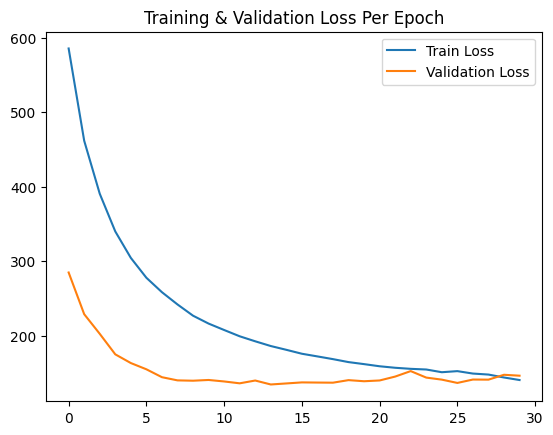

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training & Validation Loss Per Epoch")
plt.legend()
plt.savefig(os.path.join(model_folder_path,"Loss.png"), dpi=300)
plt.show()

In [ ]:
# Predict on test set
y_pred = model.predict(X_test)

311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# if encoder-decoder model then run this
y_test = y_test.reshape(y_test.shape[0],y_test.shape[2])
y_pred = y_pred.reshape(y_pred.shape[0],y_pred.shape[2])

In [ ]:
# Evaluate error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE of the future: {mae:.2f} minutes")

Test MAE of the future: 9.65 minutes


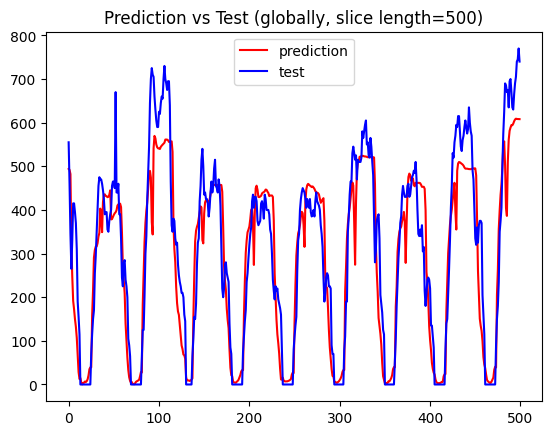

In [ ]:
plt.plot(np.sum(y_pred,axis=1)[1000:1500], color='red',label="prediction")
plt.plot(np.sum(y_test,axis=1)[1000:1500], color='blue',label="test")
plt.legend()
plt.title("Prediction vs Test (globally, slice length=500)")
plt.savefig(os.path.join(model_folder_path,"prediction_vs_test_global.png"),dpi=300)
plt.show()

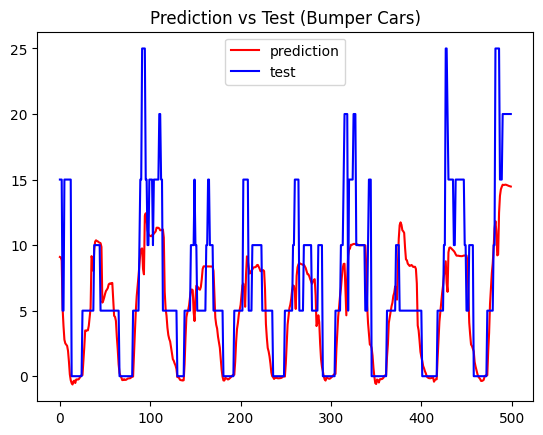

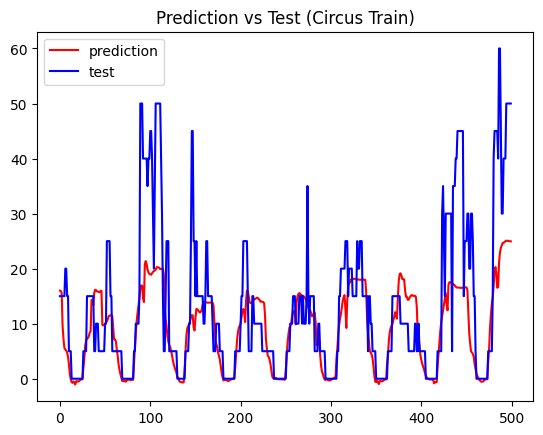

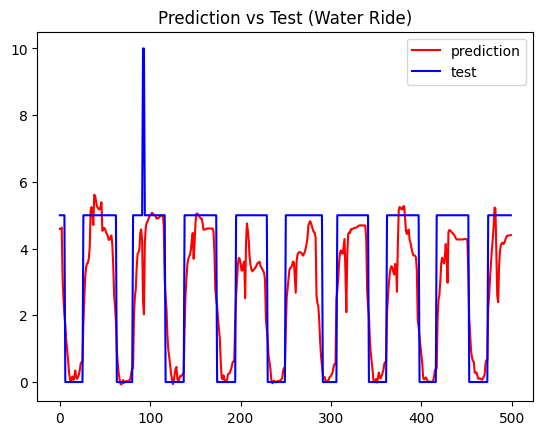

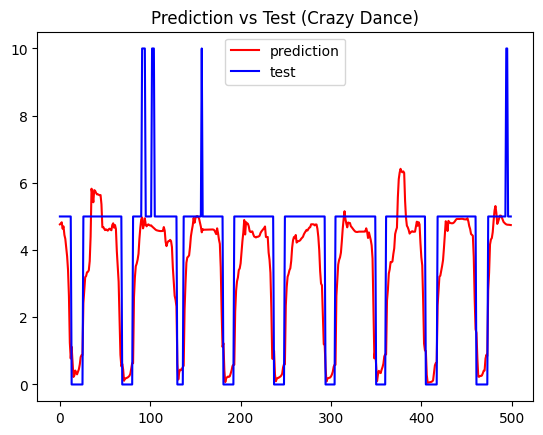

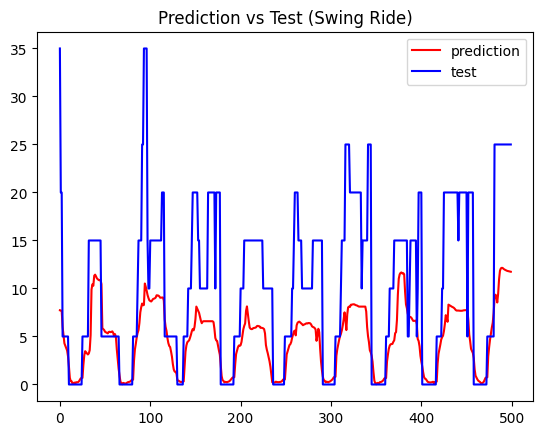

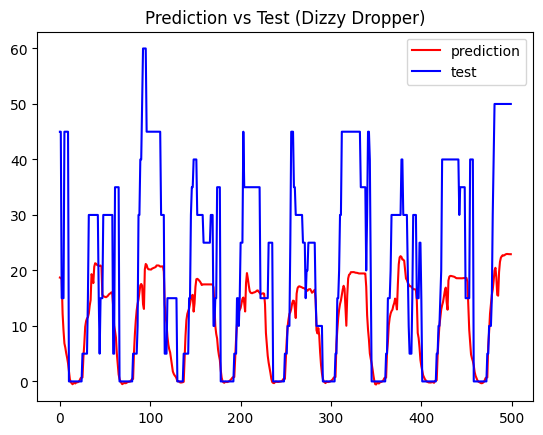

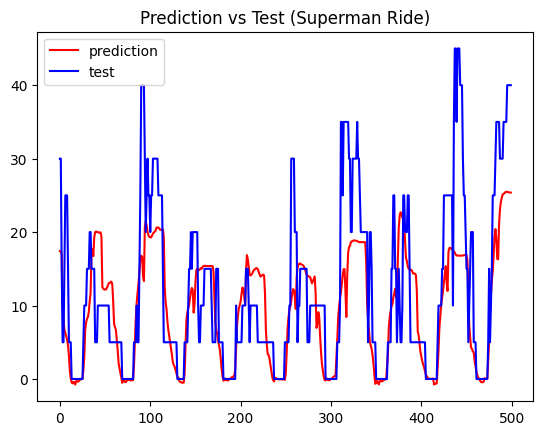

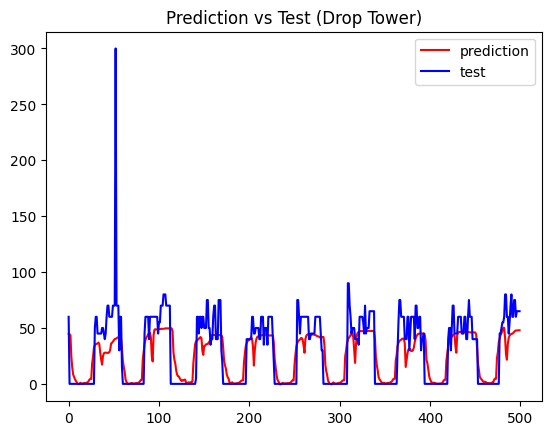

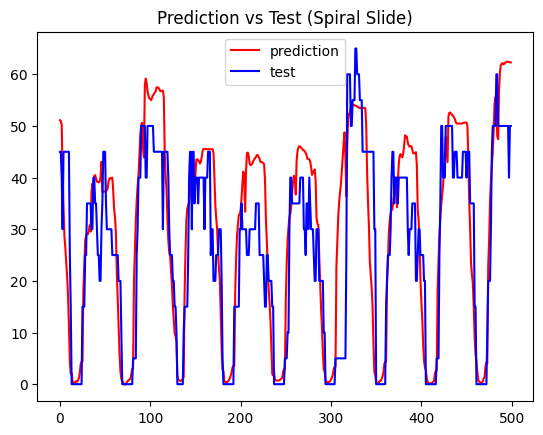

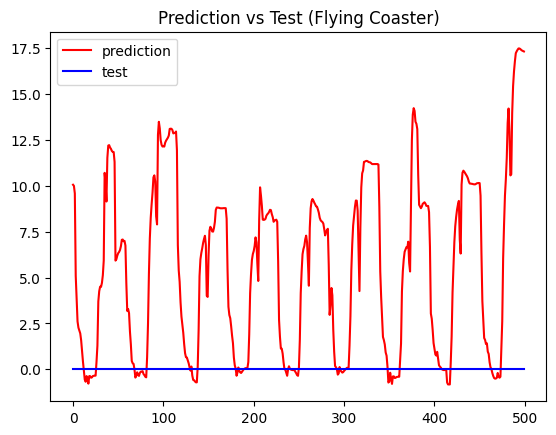

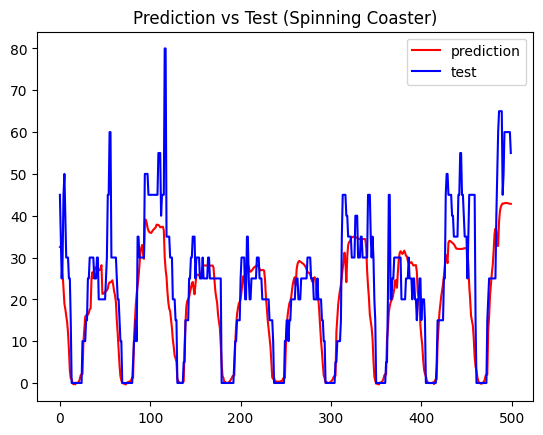

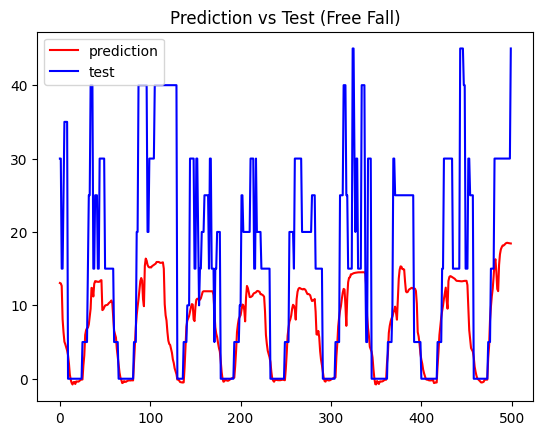

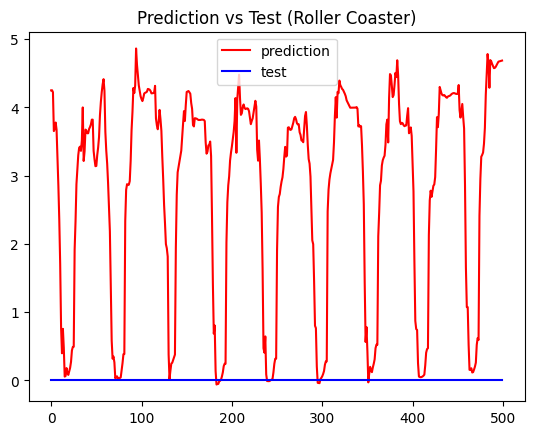

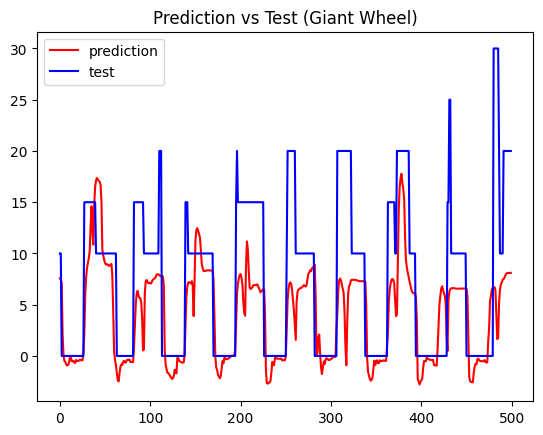

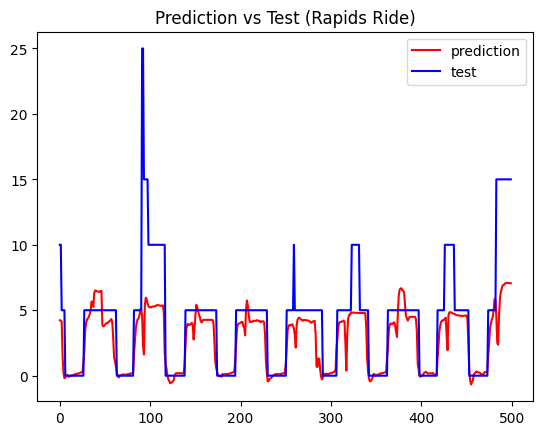

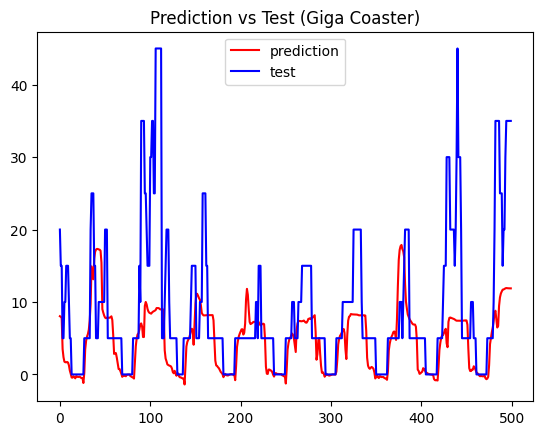

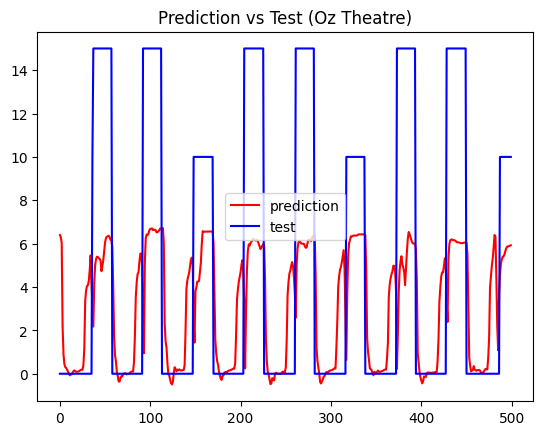

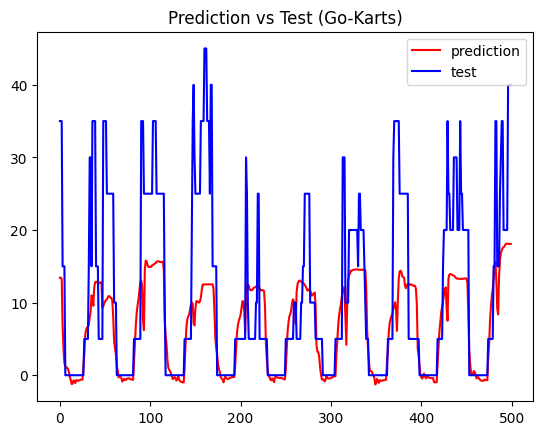

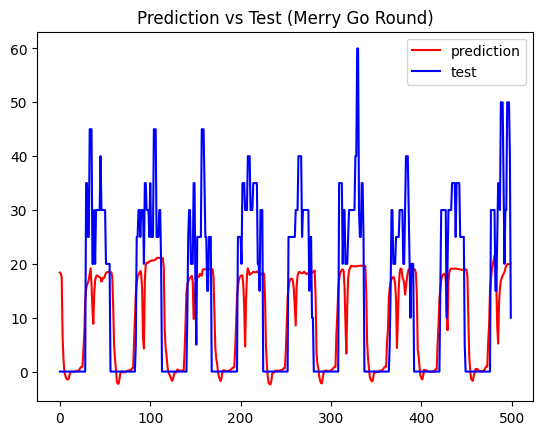

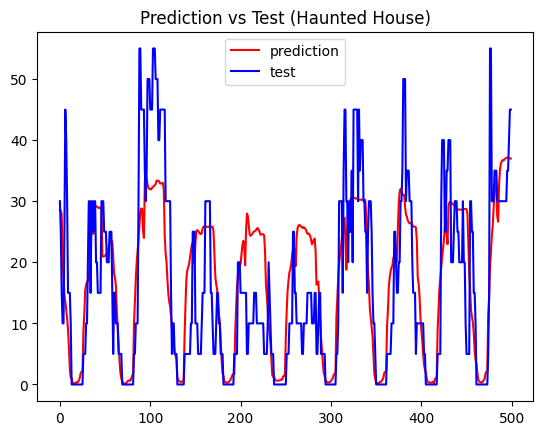

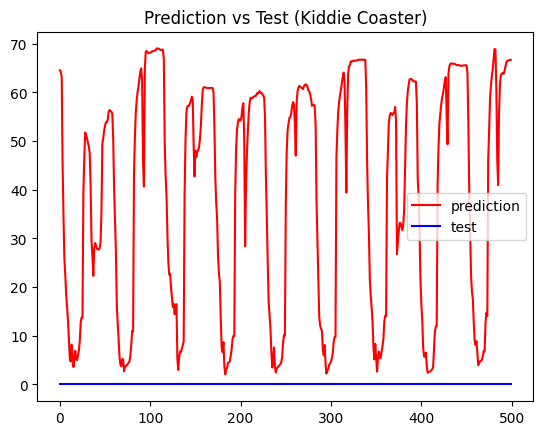

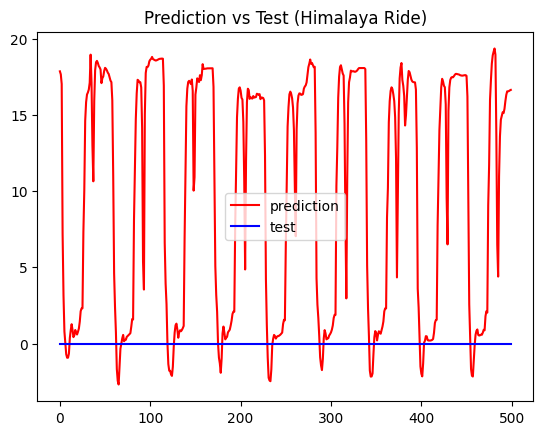

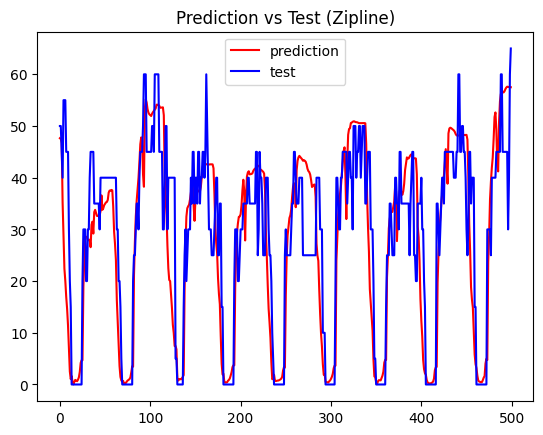

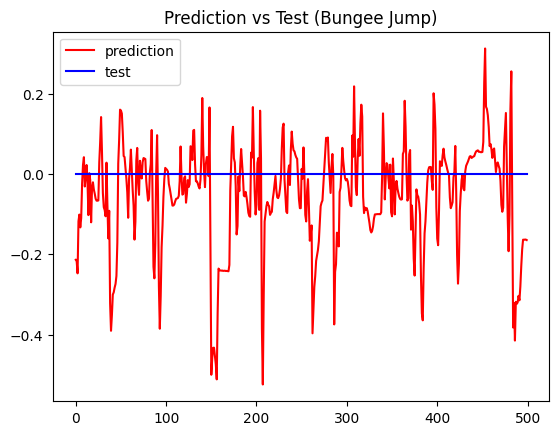

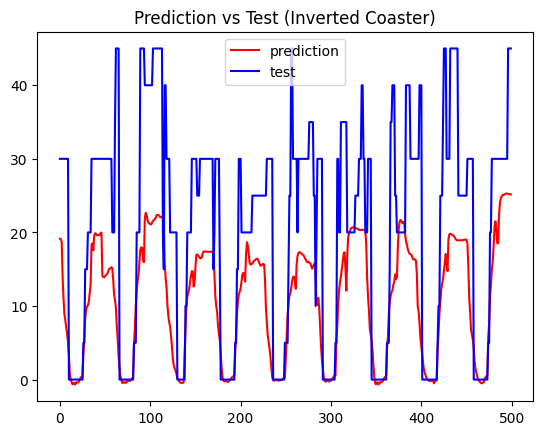

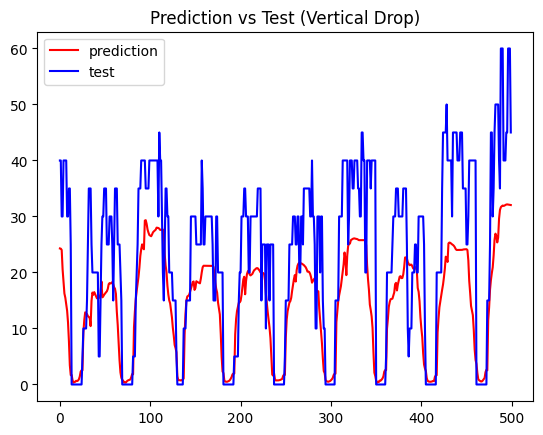

In [ ]:
entities = data["ENTITY_DESCRIPTION_SHORT"].unique()
for i in range(len(entities)):
    plt.plot(y_pred[:,i][1000:1500], color='red',label="prediction")
    plt.plot(y_test[:,i][1000:1500], color='blue',label="test")
    plt.legend()
    plt.title(f"Prediction vs Test ({entities[i]})")
    plt.savefig(os.path.join(model_folder_path,f"prediction_vs_test_{entities[i]}.png"),dpi=300)
    plt.show()